# Computational Graphs
*Christoph Heindl 2017, https://github.com/cheind/py-cgraph/*

Computational graphs (CG) are a way of representing mathematical functions and how values propagate between mathematical expressions. Among other things, the study of CG leads to deeper understanding of calculus, especially in simplifying taking derivatives by breaking complex expressions into simpler ones and chaining them up. When implemented in a programming language, CGs are able to automatically differentiate functions numerically exact or even symbolically. 

CGs thus play an important rule in mathematical function optimization, especially when computing derivatives is analytically infeasable. Supervised training of neural networks, for example, maps to optimizing (minimizing) a cost function with respect to all the neural weights in the network chained in different layers. Optimizing is usually performed using a gradient descent approach which requires first order derivatives of the cost function with respect to all the parameters in the network. As we will see, CGs not only make this doable but also provide an computationally efficient algorithm named [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) to compute the partial derivatives.

## What this is about

This notebook gives an introduction into CGs and how to implement them in Python. By the end of the notebook we will have a working framework that
 - is able to evaluate mathematical expressions represented as CGs,
 - perform [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) to find numerically exact  derivatives (up to floating point precision),
 - perform [symbolic differentiation](https://en.wikipedia.org/wiki/Symbolic_computation) to deduce higher order derivatives,
 - simplify expressions to improve performance and readability.

## What it isn't about

To keep the code basis readable there are some shortcomings to the developed framework. Foremost it is not complete. That means you won't be able to plugin every possible function and expect it return the correct result. This is mostly a problem of not providing derivatives for all elementary functions. However, the framework is structured in such a way that you will find it easy to add new blocks it and make it even more feature complete.

Also, we'll be mostly dealing with so called multi variate real-valued scalar functions $f:\mathbb {R} ^{n}\to \mathbb {R}$. In other words, we constrain our self to real values and functions that have multiple inputs but only output a single scalar. A glimpse on how to use the framework for vector-valued functions will be given in the examples section towards the end of this document.

## Introduction to computational graphs (CG)

Consider a function $$f(x,y) := (x + y)x$$

We'll call $x$ and $y$ symbols, $+$ and $*$ will be called operations / functions / nodes. When we evaluate $f$, we first add up the values of $x$ and $y$ and then multiply the result by $x$. The output of the multiplication is what we call the value of $f(x,y)$. Now, a CG is a [directed graph](https://en.wikipedia.org/wiki/Directed_graph) that represents this procedure. A graphical representation of CG for $f$ is shown below

<img src="./intro_0.png" width="400">

### Computing the value of $f(x,y)$

Computing the value of $f$ in the CG is a matter of following directed edges of the graph. Assume we want to evaluate $f(2,3)$. First, we send 2 and 3 along the out-edges of $x$ and $y$ respectively.

![](intro_1.png)

Next, we compute the value of $+$. Note that $*$ cannot be computed as one of its inputs, namely $+$ is missing.

<img src="intro_2.png" width="400">

Finally, we find value of $f$ by evaluating $*$

<img src="intro_3.png" width="400">

In evaluating the value of $f$ one needs to process all processors of a node $n$ before evaluating $n$ itself. Such an ordering on a CG is called a [topological order](https://en.wikipedia.org/wiki/Topological_sorting). 

### Computing the partial derivatives

We will now turn our attention towards computing of [partial derivatives](https://en.wikipedia.org/wiki/Partial_derivative). In order to do so, we will be a bit more abstract and use symbols for the outputs of all nodes. Like so.

<img src="intro_4.png" width="400">

Please take a moment and convince yourself that $f(x,a) = f(x,y)$. 

#### Partial derivatives of isolated nodes

Now consider any node in this CG in isolation, irrespectively of where it is located in the graph. When computing partial derivatives of isolated nodes with respect to their inputs, each input is treated as a separate abstract symbol. Therefore taking the derivative completely ignores the fact that each input symbol might be the result a complex operation by itself. By taking this perspective of isolating nodes, computation of derivatives can be simplified.

For example, take the multiplication node 

$$f(x,a) := ax$$ 

in isolation. Computing the partial derivatives of $f(x,a)$ with respect to its inputs, requires

$$\frac{\mathrm{d}f(x,a)}{\mathrm{d}a}, \frac{\mathrm{d}f(x,a)}{\mathrm{d}x}$$

to be found. Of course this will amount to

$$\frac{\mathrm{d}f(x,a)}{\mathrm{d}a}=x, \frac{\mathrm{d}f(x,a)}{\mathrm{d}x}=a$$

Similarily, for the addition node

$$a(x,y) := x+y$$

we get

$$\frac{\mathrm{d}a(x,y)}{\mathrm{d}x}=1, \frac{\mathrm{d}a(x,y)}{\mathrm{d}y}=1$$

In order to display the partial derivatives in the CG diagrams, we will use backward oriented arrows between nodes to which we attach the corresponding partial derivatives as shown below.

<img src="intro_5.png" width="400">

For each node, we consider all of its inputs. For each input arrow we generate a corresponding backward oriented arrow and assign it the partial derivative of the node's output with respect to the input arrow. Note that if a node has multiple inputs and a single output, we call the partial derivatives with respect to all inputs the [gradient](https://en.wikipedia.org/wiki/Gradient).

#### Partial derivatives of nodes with respect to other nodes

To compute the partial derivative for any node $n$ with respect to function $f(x,y):=(x+y)x$, or $f(x,a)$ in the CG diagram, one needs to
 1. Find all the backward pathes starting from $f(x,a)$ reaching $n$.
 1. For each path build the product of partial derivatives along its chain of backward arrows.
 1. Sum over all path products of partial derivatives.
 
For example, the partial derivative of $\frac{\mathrm{d}f(x,a)}{\mathrm{d}y}$ amounts to

$$\frac{\mathrm{d}f(x,y)}{\mathrm{d}y} = 
\frac{\mathrm{d}f(x,a)}{\mathrm{d}f(x,a)}
\frac{\mathrm{d}f(x,a)}{\mathrm{d}a(x,y)}
\frac{\mathrm{d}a(x,y)}{\mathrm{d}y}
$$

There is only one backward oriented path from $f(x,a)$ to $y$, so there is no summation. Note that $f(x,a)$ is equivalent to $f(x,y)$ by construction. By substitution (see CG diagram above) we find

$$\frac{\mathrm{d}f(x,y)}{\mathrm{d}y} = 1*x*1 = x$$

Finding $\frac{\mathrm{d}f(x,y)}{\mathrm{d}x}$ is very similar, except that this time we have two paths in which $x$ can be reached from $f(x,a)$.

$$\frac{\mathrm{d}f(x,y)}{\mathrm{d}x} = 
    \frac{\mathrm{d}f(x,a)}{\mathrm{d}f(x,a)}
    \frac{\mathrm{d}f(x,a)}{\mathrm{d}a(x,y)}
    \frac{\mathrm{d}a(x,y)}{\mathrm{d}x} +
    \frac{\mathrm{d}f(x,a)}{\mathrm{d}f(x,a)}
    \frac{\mathrm{d}f(x,a)}{\mathrm{d}x}   
$$

By subsitution we get

$$\frac{\mathrm{d}f(x,y)}{\mathrm{d}x} = 1*x*1 + 1*a(x,y) = x + (x+y) = 2x+y$$

With these tools you are able to compute the derivatives of 'any' function, no matter how complex it is. Here's what you do:
First, decomposing the function into operations simple enough, so you know how to compute isolated partial derivatives for individual nodes. Next, build a CG based on your decomposition. Apply the 3-step algorithm above to find partial derivatives of any two connected nodes in the CG (usually you do this for the input variables).

### Backpropagation

While you can use the above recipe to compute partial derivatives for any two nodes connected by a path in the CG, it should be noted that it is not computationally efficient yet. Notice the terms 

$$\frac{\mathrm{d}f(x,a)}{\mathrm{d}f(x,a)}\frac{\mathrm{d}f(x,a)}{\mathrm{d}a(x,y)}$$

appear in computations of both $\frac{\mathrm{d}f(x,y)}{\mathrm{d}x}$ and $\frac{\mathrm{d}f(x,y)}{\mathrm{d}y}$. A more clever way to spare redundant computations is this: Turn the backward arrows into a computational graph on its own and apply a topological sorting to it. This is the same procedure as we've seen in evaluting a CG, but this time the order is reversed (as backward edges are used). Traverse the CG, starting from $f(x,a)$ in order and perform the following for each node $n$.
 1. Compute $\frac{\mathrm{d}f(x,a)}{\mathrm{d}n}$ by summing over all incoming backward edges (backward arrows are now node inputs)
 1. Compute the isolated partial derivatives with respect to forward incoming edges $i$ as $\frac{\mathrm{d}n}{\mathrm{d}n_i}$
 1. For each outgoing backward edge compute the product $\frac{\mathrm{d}f(x,a)}{\mathrm{d}n}\frac{\mathrm{d}n}{\mathrm{d}n_i}$.

The above procedure in pictures looks like this. First, we let the value along the very first backward edge be 1. This will allow us to kickstart the procedure above.

<img src="intro_6.png" width="400">

Next we process $f(x,a)$

<img src="intro_7.png" width="400">

Then we process $a(x,y)$

<img src="intro_8.png" width="400">

Finally at $x$ and $y$ we would only perform the first step of the above algorithm to correctly compute $\frac{\mathrm{d}f(x,y)}{\mathrm{d}x}$ and $\frac{\mathrm{d}f(x,y)}{\mathrm{d}y}$

When computing the partial derivatives numerically, one would evaluate the terms at the corresponding values that propagated through the graph in the forward (value) pass. Reconsidering our numeric example from before, were we let $x=2$ and $y=3$ we'd get the following graph

<img src="intro_9.png" width="400">

Finally at $x$ and $y$ we'd get $\frac{\mathrm{d}f(x,y)}{\mathrm{d}x}=7$ and $\frac{\mathrm{d}f(x,y)}{\mathrm{d}y}=2$. Mind you that we also know the partial derivatives with respect to $f(x,y)$ for all the intermediate nodes (just the addition in this example). All it took was visiting each node twice, once when computing the node's output value and once in the backward pass.

The chained forward-backward passes as explained above is also known as reverse [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), a technique to numerically evaluate the partial derivatives of a function composed of a set of operations for which isolated partial derivatives are known. Note, auto-diff can be executed also in forward mode which won't be covered in this text.

Note that backpropagation in neural network training refers not only to backpropagating partial derivatives of a loss function with respect to neural weights and biases, but also means application of gradient descent methods to update the parameters accordingly, so that the objective function is mininmized. We will come back to that when doing function optimization.

### Summary and Outlook

Up to this point computational graphs (CG) were introduced. A method to compute the value of a CG was presented that used forward propagation of values. Next, a recipe to compute the partial derivatives through backward traversal was given. We've improved the initial formulation by factoring out common terms in what lead to the backpropagation algorithm.

## Expression trees

Before diving into code, we need to cover the concept of [expression trees](https://en.wikipedia.org/wiki/Binary_expression_tree). Expression trees will be used to represent function decompositions in Python code to be developed. While there are not a fundamentally new concept they deserve some words at this point.

An expression tree is similar to the computational graphs introduced, but the arrows by default point backwards. It turns out that constructing function expression in a tree like manner (top node is the function itself, function parameters are leafs) simplifies development dramatically.

Take the CG of the toy example used $f(x,y)=(x+y)x$

<img src="intro_0.png" width="400">

The following expression tree represents the same function

<img src="exp_tree.png" width="400">

Notice that we now have a tree like structure. Our root node is the final operation to be executed to receive the result of $f(x,y)$. Also notice that $x$ shows up twice. Finding the value of an expression tree requires to compute values for nodes in lower layers first and bubble information up towards the root node. Backpropagation on the other hand ist just a matter of following the forward edges. Again, when computing derivatives, a summation over all paths from the top that lead to a given node will be performed.

## CGraph 

CGraph is the name of the Python library to be developed during the remainder of this notebook. While the code inside the notebook is functional a separate, self-contained and enhanced implementation of CGraph is available [cgraph.py](../cgraph.py). 

CGraph performs numeric and symbolic differentiation using backpropagation.

```Python
import cgraph as cg

x = cg.Symbol('x')
y = cg.Symbol('y')
z = cg.Symbol('z')

f = (x * y + 3) / (z - 2)

# Evaluate function
cg.value(f, {x:2, y:3, z:3}) # 9.0

# Partial derivatives (numerically)
d = cg.numeric_gradient(f, {x:2, y:3, z:3})
d[x] # df/dx 3.0
d[z] # df/dz -9.0

# Partial derivatives (symbolically)
d = cg.symbolic_gradient(f)
cg.simplify(d[x]) # (y*(1/(z - 2)))
cg.value(d[x], {x:2, y:3, z:3}) # 3.0

# Higher order derivatives
ddx = cg.symbolic_gradient(d[x])
cg.simplify(ddx[y]) # ddf/dxdy
# (1/(z - 2))
```

Python 3.5 will be used for development. The reader is assumed to be familiar with its concepts including generators and decorators. Also a technique called monkey patching will be used to iteratively refine classes already introduced.

### Representing expression trees
First we need to come up with a way to represent expression trees in Python code. Naturally, we will have base class `Node` that manages child references and derived classes that actually implement operations, symbols and constants.

In [1]:
class Node:

    def __init__(self, nary=0):
        self.children = [None]*nary

    def __repr__(self):
        return self.__str__()

`Node` for now just tracks references to its children. Note that operations can be binary (e.g. addition), unary (e.g cosine) or don't have children at all (e.g. symbols). We can also think of n-ary functions such as summation. Next, we'll define the leaf nodes `Symbol` and `Constant`

In [2]:
class Symbol(Node):

    def __init__(self, name):
        super(Symbol, self).__init__(nary=0)
        self.name = name

    def __str__(self):
        return self.name

    def __hash__(self):
        return hash(self.name)            
    
    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return self.name == other.name      
        else:
            return False

Symbols are identified by their name, like $x$, and they don't have any children. When printed we print the name of the symbol. 

In [3]:
class Constant(Node):

    def __init__(self, value):
        super(Constant, self).__init__(nary=0)
        self.value = value

    def __str__(self):
        return str(self.value)

`Constants` are 'immutable' values. Next we start to add operations. For this notebook we will provide addition, multiplication. [cgraph.py](../cgraph.py) has more operations defined and once you know how to implement them it will be easy for you to add new ones.

In [5]:
class Add(Node):

    def __init__(self):
        super(Add, self).__init__(nary=2)

    def __str__(self):
        return '({}+{})'.format(str(self.children[0]), str(self.children[1]))
    
class Mul(Node):

    def __init__(self):
        super(Mul, self).__init__(nary=2)

    def __str__(self):
        return '({}*{})'.format(str(self.children[0]), str(self.children[1]))

`Add` and `Mul` don't do much yet expect that stating that they are binary functions plus some pretty printing (recursively calling `__str__` on its children). Next, well just have a helper function that builds our toy function $f(x,y)=(x+y)x$. This looks a bit clumsy right now but we'll improve the syntax as we go.

In [30]:
def gen_f(x, y): 
    a = Add()
    a.children[0] = x
    a.children[1] = y
    
    m = Mul()
    m.children[0] = a
    m.children[1] = x
    
    return m

x = Symbol('x')
y = Symbol('y')
f = gen_f(x, y)
f

((x + y)*x)

### Computing function values

Next we'll turn our attention towards computing values of functions represented as expression trees. As mentioned earlier to compute the value, we'll need to bubble up information from layers further down in hierarchy up to the root. Traversing expression trees can be performed in multiple ways. What we are looking for is [depth-first-search](https://en.wikipedia.org/wiki/Depth-first_search) in [post-order](https://en.wikipedia.org/wiki/Tree_traversal). There are many ways to implement the traversal, i've chosen the recursive generator approach because of its shortness.

In [31]:
def postorder(node):
    for c in node.children:
        yield from postorder(c)
    yield node

In [32]:
[n for n in postorder(f)]

[x, y, (x + y), x, ((x + y)*x)]

As you can see, children are evaluated before their parents. Excactly what's needed for computing function values. Next, define the method that computes the forward pass, i.e the value of the function.

In [33]:
def values(f, fargs):
    """Returns a dictionary of computed values for each node in the expression tree including `f`."""
    v = {}
    v.update(fargs)
    for n in postorder(f):
        if not n in v:
            v[n] = n.compute_value(v)
    return v

This method calls for each node `compute_value(values)` and expects the node to return its value. Since we haven't defined this function for our nodes yet, it's time to do so. Also note that `fargs` will be assumed to contain the values for the symbols in the expression tree.

In [34]:
# Monkey patching for compute_value
Symbol.compute_value = lambda self, values: values[self]
Constant.compute_value = lambda self, values : self.value
Add.compute_value = lambda self, values: values[self.children[0]] + values[self.children[1]]
Mul.compute_value = lambda self, values: values[self.children[0]] * values[self.children[1]]

After monkey patching in `compute_value` for all nodes we can evaluate `f` by

In [35]:
values(f, {x:2, y:3})[f]

10

Since `values` computes all the values even for intermediate nodes we need to add `[f]` as a postfix. Just accessing the value of `f` will however be so common task that we provide a shortcut for it named `value`.

In [37]:
def value(f, fargs):
    return values(f, fargs)[f]

value(f, {x:2, y:3})

10

### Syntactic sugar

Before continuing it makes sense to use Python's internal methods for 'overloading' the `+` and `*` operation for Nodes. First, we'll define a decorator that will wrap plain numbers to `Constants`.

In [53]:
from numbers import Number

def wrap_args(func):
    """Wraps function arguments that are numbers as Constant objects."""
    def wrapped(*args, **kwargs):
        new_args = []
        for a in args:
            if isinstance(a, Number):
                a = Constant(a)
            new_args.append(a)
        return func(*new_args, **kwargs)
    return wrapped

Next, we'll define some free functions that perform the 'lengthy' addition and multiplication. By convention these free functions will start with the prefix `sym_` (for symbolic). When adding new functionality you should always provide such a function (e.g `sym_pow, sym_cos`).

In [54]:
@wrap_args
def sym_add(x, y):
    n = Add()
    n.children[0] = x
    n.children[1] = y
    return n

@wrap_args
def sym_mul(x, y):
    n = Mul()
    n.children[0] = x
    n.children[1] = y
    return n

Finally we monkey patch `Node` to support `+` and `*` operations

In [55]:
Node.__add__ = lambda self, other: sym_add(self, other)
Node.__radd__ = lambda self, other: sym_add(other, self)
Node.__mul__ = lambda self, other: sym_mul(self, other)
Node.__rmul__ = lambda self, other: sym_mul(other, self)

Note that the `__r*` methods are also overloaded so that expressions of the type `n*3` and `3*n` work equally well. With that we can rewrite `gen_f` introduced by simply saying

In [58]:
f = (x + y)*x

### Computing numeric derivatives

Next we will turn our attention to the backpropagation for computing numerical derivatives. For this we first need another traversal, one that visits all nodes on the same level before moving on to the next level. Such a traversal is called [breadth-first-search](https://en.wikipedia.org/wiki/Breadth-first_search) and it can also be implemented in numerous ways.

The way it is implemented here is based on a generator that uses a queue. However when performing backpropagation, we'd like to communicate values back to the generator for each children of the current node. We then expect the handed values to be passed to us when we visit the corresponding child. Doing so turns the generator into [co-routine](https://en.wikipedia.org/wiki/Coroutine).

In [59]:
def bfs(node, node_data):
    q = [(node, node_data)]
    while q:
        t = q.pop(0)
        node_data = yield t
        for idx, c in enumerate(t[0].children):
            q.append((c, node_data[idx]))

Next, `numeric_gradient` is presented. It takes an expression tree and function arguments for the contained symbols and computes all numeric partial derivatives with respect to the root node passed.

In [68]:
from collections import defaultdict

def numeric_gradient(f, fargs):
    vals = values(f, fargs)
    derivatives = defaultdict(int) # by default 0 is the derivative for unknown nodes.

    gen = bfs(f, 1)
    try:
        n, in_grad = next(gen)
        while True:
            derivatives[n] += in_grad
            local_grad = n.compute_gradient(vals)
            n, in_grad = gen.send([l*in_grad for l in local_grad])
    except StopIteration:
        return derivatives

First, numeric_gradient performs a forward pass to compute all function values. Next, breadth-first-search is kicked of by f and a value of 1. Then for each node visited we accumulate incoming partial derivatives send along the edges. Next, the local isolated gradient is computed. We communicate back the local gradient times incoming partial derivative as explained in the backpropagation introduction before. Finally a dictionary of partial derivatives for each operation is returned.

Also note that we need to provide implementations of `compute_gradient(values)` for each node. `compute_gradient` is expected to take in a values dictionary and return the isolated partial derivative for every children in array form. As always, lets monkey patch.

In [63]:
# Monkey patch for compute_gradient
Symbol.compute_gradient = lambda self, values: [] # Nothing todo
Constant.compute_gradient = lambda self, values: [] # Nothing todo

Add.compute_gradient = lambda self, values: [1, 1] # dx+y/dx = 1, dx+y/dy = 1
Mul.compute_gradient = lambda self, values: [values[self.children[1]], values[self.children[0]]] # dx*y/dx = y, dx*y/dy = x

The isolated gradients for `Add` and `Mul` should look familiar to you. If not, go back to the introduction on computational graphs. With that in place we can now compute numeric derivatives like so

In [70]:
numeric_gradient(f, {x:2, y:3})

defaultdict(int, {((x + y)*x): 1, y: 2, x: 7, (x + y): 2})

As you can see $\frac{\mathrm{d}f(x,y)}{\mathrm{d}x}\Bigr|_{\substack{x=2\\y=3}} = 7$ and $\frac{\mathrm{d}f(x,y)}{\mathrm{d}y}\Bigr|_{\substack{x=2\\y=3}} = 2$. But the dictionary provides more, also the derivative w.r.t $(x+y)$ is given! Some more examples, to sure the power of this system

In [72]:
numeric_gradient(x*x+y*y, {x:2, y:3})

defaultdict(int, {(y*y): 1, ((x*x) + (y*y)): 1, y: 6, (x*x): 1, x: 4})

In [77]:
z = Symbol('z')
numeric_gradient((x+3)*(y+4)*z*z, {x:2, y:3, z:5})

defaultdict(int,
            {y: 125,
             (((x + 3)*(y + 4))*z): 5,
             z: 350,
             (x + 3): 175,
             3: 175,
             ((x + 3)*(y + 4)): 25,
             ((((x + 3)*(y + 4))*z)*z): 1,
             4: 125,
             (y + 4): 125,
             x: 175})

### Computing symbolic derivatives

Now that we can compute numerica derivates one might wonder if we could do the same symbolically, i.e instead of returning a number we return some expression tree. Clearly such a feature would be beneficial as it would allow computation of higher order derivatives. Additionally, pre-factoring the derivative expressions might be favorable when invoking the derivative evaluation multiple times.

Turns out modifying the numeric gradient computation for symbolic computation is straight forward. All that needs to be done is to return appropriate `Node`s instead of numeric values. Infact with the overloaded `+` and `*` operations in place for nodes, the symbolic gradient computation looks nearly identical to `numeric_gradient` as defined earlier.

Here it is, `symbolic_gradient`

In [78]:
def symbolic_gradient(f):
    derivatives = defaultdict(lambda: Constant(0))
    
    gen = bfs(f, Constant(1))
    try:
        n, in_grad = next(gen) # Need to use edge info when expressions are reused!
        while True:
            derivatives[n] = derivatives[n] + in_grad
            local_grad = n.symbolic_gradient()
            n, in_grad = gen.send([l * in_grad for l in local_grad])
    except StopIteration:
        return derivatives

Only differences: we use `Constant` instead of numbers directly and a method to be defined `symbolic_gradient` is invoked. One can probably guess that the operations `+` and `*` call the corresponding overloads for `Node` objects introduced earlier. As always, let's monkey patch for `symbolic_gradient`.

In [79]:
# Monkey patch for symbolic_gradient
Symbol.symbolic_gradient = lambda self: [] # Nothing todo
Constant.symbolic_gradient = lambda self: [] # Nothing todo

Add.symbolic_gradient = lambda self: [Constant(1), Constant(1)] # dx+y/dx = 1, dx+y/dy = 1
Mul.symbolic_gradient = lambda self: [self.children[1], self.children[0]] # dx*y/dx = y, dx*y/dy = x

Again, replace numbers by Constants and for `Mul` just return the opposite child expression. Let's test.

In [80]:
symbolic_gradient(f)

defaultdict(<function __main__.symbolic_gradient.<locals>.<lambda>>,
            {((x + y)*x): (0 + 1),
             y: (0 + (1*(x*1))),
             x: ((0 + ((x + y)*1)) + (1*(x*1))),
             (x + y): (0 + (x*1))})

Have a look at $x$. It claims derivate is equal to `((0 + ((x + y)*1)) + (1*(x*1)))`. After massaging the terms you indeed find that this is the same as $2x+y$. Although not very readable, the reported results are correct. Something we will tackle in the next section when we begin to simplify expressions. 

Since the returned dictionary contains expressions, we can apply all our arsenal of functions developed so far onto them.

In [88]:
d = symbolic_gradient(f)
print('df/dx at (x=2,y=3) is {}'.format(value(d[x], {x:2, y:3})))
print('df/dy at (x=2,y=3) is {}'.format(value(d[y], {x:2, y:3})))

# Let's try second order derivatives
ddx = symbolic_gradient(d[x])
ddy = symbolic_gradient(d[y])
print('ddf/dxdx at (x=2,y=3) is {}'.format(value(ddx[x], {x:2, y:3})))
print('ddf/dxdy at (x=2,y=3) is {}'.format(value(ddx[y], {x:2, y:3})))
print('ddf/dydx at (x=2,y=3) is {}'.format(value(ddy[x], {x:2, y:3})))
print('ddf/dydy at (x=2,y=3) is {}'.format(value(ddy[y], {x:2, y:3})))

df/dx at (x=2,y=3) is 7
df/dy at (x=2,y=3) is 2
ddf/dxdx at (x=2,y=3) is 2
ddf/dxdy at (x=2,y=3) is 1
ddf/dydx at (x=2,y=3) is 1
ddf/dydy at (x=2,y=3) is 0


### Adding new operations

Adding new operations to CGraph is not hard. The following recipe sums up the necessary steps.
 1. Add a new class inheriting `Node`
 1. Add implementations for `compute_value`, `symbolic_gradient` and optionally for `compute_gradient`
 1. Provide one or more free function with prefix `sym_*` that connects arguments as inputs for your operation. Use `@wrap_args` where appropriate.
 1. Optionally provide and implementation for `__str__`
 1. Optionally provide new `__*__` methods in `Node` to support improved syntax delegating to `sym_*` methods.
 
Note that `compute_gradient` is optional, as it can always be mimicked by `symbolic_gradient` followed by `value`. 

A word of caution: when computing numeric gradients through `compute_gradient` you might find yourself in a position of potentially dividing by zero or raising any other math expection. When this happens on path you are even not interested in, gradient computation will stop. For example consider $f(x,y) = x^y$ and let $x=-1, y=2$. Then when evaluating the gradient for $y$ you will find that it corresponds to $x^y*log(x)$. Unfortunately $x$ is negative and so the value can not be computed. Python raises an exception and gradient computation fails.

CGraph handles this by using `NAN`s instead of exceptions. Almost all operations that invoke `NAN`s result in `NAN`, so they propagate nicely. In [CGraph](../cgraph.py) a function named `nan_on_fail` is used to catch math exceptions and instead return `NAN`. See `Div` for example usage.

### Expression simplification

Earlier we saw that symbolic differentiation produces hardly readable expressions, such as `((0+((x+y)∗1))+(1∗(x∗1)))`. In this section we will see how to simplify such expressions. Not only will this improve readability but also performance as lesser nodes need to be evaluated (pays off especially when you invoke it many times after simplification).

The way CGraph implements expression simplification is by traversing the computational graph, while trying to apply simplification rules. Each rule is given a node and may produce a simplier version of that node. The new node 'replaces' the old node in an expression tree that is formed in parallel. That means that we won't fiddle around with the original expression tree given, but rather generate a expression tree that represents a simplified version of the original one.

First we will implement a rule filter decorator, a helper function and a single rule.

In [89]:
def applies_to(*klasses):
    """Decorates rule functions to match specific nodes in simplification."""

    def wrapper(func):
        def wrapped_func(node):
            if isinstance(node, klasses):
                return func(node)
            else:
                return node
        return wrapped_func
    return wrapper

Next, a helper function to check if a node is 'Constant' and has a specific value.

In [90]:
def is_const(node, value=None):
    if isinstance(node, Constant):
        if value is not None:
            return node.value == value
        else:
            return True            
    return False

The first rule will be the rule for multiplication with the identity element (1). Notice that $x*1=x$.

In [91]:
@applies_to(Mul)
def mul_identity_rule(node):
    if is_const(node.children[0], 1):
        return node.children[1]
    elif is_const(node.children[1], 1):
        return node.children[0]
    else:
        return node

First notice that this rule will only apply to `Mul` nodes. Next, if any of the children is a constant with value 1, it returns the other one.

Next, we provide the implementation of simplify. It uses depth-first-search traversal and invokes the rules for each node visited. In parallel it builds a new expression tree.

In [101]:
import copy

rules = [mul_identity_rule]
def simplify(node):
    """Returns a simplified version of the forward graph associated with the given node."""
    
    nodemap = {}
    for n in postorder(node):
        if isinstance(n, Symbol):
            continue

        nc = copy.copy(n)
        for i in range(len(nc.children)):
            c = nc.children[i]
            nc.children[i] = nodemap.get(c, c)
        for r in rules:
            nc = r(nc)
        nodemap[n] = nc
        
    return nodemap[node]

Applied to the expression from before

In [102]:
d = symbolic_gradient(f)
print(d[x]) # Hardly readable
print(simplify(d[x])) # A bit better

((0 + ((x + y)*1)) + (1*(x*1)))
((0 + (x + y)) + x)


Quite an improvement. Here's one more rule for simplifying $x+0=x$

In [103]:
@applies_to(Add)
def add_identity_rule(node):
    if is_const(node.children[0], 0):
        return node.children[1]
    elif is_const(node.children[1], 0):
        return node.children[0]
    else:
        return node
    
rules.append(add_identity_rule)

In [104]:
print(simplify(d[x])) # Even better

((x + y) + x)


Note that your are not restrictued to rules that just use the direct children. Your rule can look for any pattern in the subtree given by the input node. Here's one last rule that I would like to advertise: a rule that turns any subgraph that consists of `Constants` only into a single constant.

In [108]:
k = x + x + x + x + x
d = symbolic_gradient(k)
print(d[x])
print(simplify(d[x]))

(((((0 + (1*1)) + (1*(1*1))) + (1*(1*(1*1)))) + (1*(1*(1*(1*1))))) + (1*(1*(1*(1*1)))))
((((1 + 1) + 1) + 1) + 1)


Here's the rule. What's special about it is that it uses `value` without passing any numeric values for symbols.

In [112]:
def eval_to_const_rule(node):
    try:
        k = value(node, {})
        return Constant(k)
    except KeyError:
        return node
    
rules.append(eval_to_const_rule)
print(simplify(d[x]))

5


### Function optimization

Now with all the puzzle-pieces in place and a fully working symbolic computation engine, we will put it into practice and use it for function optimization. In particular we will be dealing with least squares problems in which the residuals are linear, though nothing prevents you from applying it to other non-linear problems.

Our secenario is as follows: Given a set of noisy two-dimensional points fit a straight line. Everyone whose done ordinary linear least square regression knows that there is a 'closed-form' solution to the problem that involves nothing but a couple of matrix multiplications and an inversion. However, here we shall use the best-fit solution only as reference and concentrate more on gradient descent methods that are also the driving horses for training neural networks.

For the time being, we'll be using [cgraph.py](../cgraph.py) directly, as it contains few operations that we will be using. The complete example can be found [example_optimize.py](../example_optimize.py).

In [116]:
import sys
sys.path.append('..')
import cgraph as cg

First, we define a function that generates a set of noisy points from an ideal line parametrized as $y = w0*x+w1$

In [123]:
import numpy as np
import matplotlib.pyplot as plt

def generate_points(n, k, d):
    x = np.linspace(0, 10, n)
    y = x * k + d + np.random.normal(scale=0.15, size=n)
    return np.vstack((x,y))

# Parameters of ideal line
k = 0.8
d = 2.0

samples = generate_points(20, k, d)

Let's plot the samples

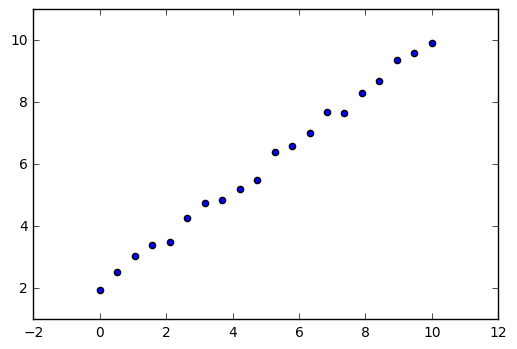

In [124]:
plt.scatter(samples[0,:], samples[1,:])
plt.show()

Next, define the objective function to be minimized
$$f(w_0,w_1;x_0..x_n, y_0..y_n) = \sum_i^n{(w_0*x_i + w_1 - y_i)^2}$$
with respect to the unknown parameters $w_0$ and $w_1$.

It is straight forward to represent the above function with CGraph as follows

In [129]:
def sum_residuals_squared(w0, w1, xy):
    n = xy.shape[1]
    residuals = []
    for i in range(n):
        r = w0 * xy[0,i] + w1 - xy[1,i]
        residuals.append(cg.sym_sqr(r))

    return cg.sym_sum(residuals) / n

w0 = cg.Symbol('w0')
w1 = cg.Symbol('w1')

f = sum_residuals_squared(w0, w1, samples)

Note the `/n` is a normalizing constant is additional. It serves the purpose that gradients steps taken later are not affected by the number of samples used. `f` now is an expression tree and looks like so

In [131]:
f

((((((((((((((((((((((((w0*0.0) + w1) - 1.95910976998)*(((w0*0.0) + w1) - 1.95910976998)) + ((((w0*0.526315789474) + w1) - 2.53499641035)*(((w0*0.526315789474) + w1) - 2.53499641035))) + ((((w0*1.05263157895) + w1) - 3.04489175005)*(((w0*1.05263157895) + w1) - 3.04489175005))) + ((((w0*1.57894736842) + w1) - 3.40223243296)*(((w0*1.57894736842) + w1) - 3.40223243296))) + ((((w0*2.10526315789) + w1) - 3.48724533466)*(((w0*2.10526315789) + w1) - 3.48724533466))) + ((((w0*2.63157894737) + w1) - 4.27242793949)*(((w0*2.63157894737) + w1) - 4.27242793949))) + ((((w0*3.15789473684) + w1) - 4.74797600226)*(((w0*3.15789473684) + w1) - 4.74797600226))) + ((((w0*3.68421052632) + w1) - 4.86374907951)*(((w0*3.68421052632) + w1) - 4.86374907951))) + ((((w0*4.21052631579) + w1) - 5.20844191314)*(((w0*4.21052631579) + w1) - 5.20844191314))) + ((((w0*4.73684210526) + w1) - 5.49611791858)*(((w0*4.73684210526) + w1) - 5.49611791858))) + ((((w0*5.26315789474) + w1) - 6.41043405517)*(((w0*5.26315789474) + w

First, let's see what the reference best fit implementation gives. I won't go into details. In case you are interested see [ordinary-least-squares](https://en.wikipedia.org/wiki/Ordinary_least_squares).

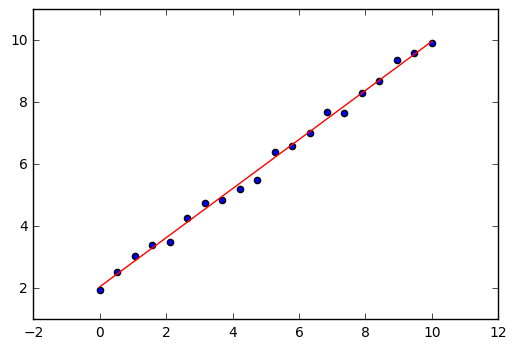

In [133]:
def least_squares_fit(xy):
    """Returns the line parameters through ordinary least squares regression."""

    A = np.ones((xy.shape[1], 2))    
    A[:,0] = xy[0,:].T
    b = xy[1,:].T

    return np.dot(np.dot(np.linalg.inv(np.dot(A.T,A)), A.T), b)

s_fit = least_squares_fit(samples)

plt.plot([0, 10], [0*s_fit[0]+s_fit[1], 10*s_fit[0]+s_fit[1]], color='r', linestyle='-', label='Least Squares')
plt.scatter(samples[0,:], samples[1,:])
plt.show()

### Steepest descent

[Steepest descent](https://en.wikipedia.org/wiki/Method_of_steepest_descent) is an iterative optimization method that, given an initial guess, finds a better guess by taking a step in the direction of the negative gradient. Once the norm of the gradient is close to zero sufficently, one claims to have found a stationary point (local minimum).

This method is a so called first-order method as it requires only first order derivatives. With CGraph it can be implemented in the following way.

In [136]:
def steepest_descent(f, w0, w1, guess):    
    lam = 0.02

    for i in range(200):   
        df = cg.numeric_gradient(f, guess)

        guess[w0] -= lam * df[w0]
        guess[w1] -= lam * df[w1]

    print('Steepest descent solution {}, {}'.format(guess[w0], guess[w1]))
    print('Error {}'.format(cg.value(f, guess)))

    return guess

In each iteration the method takes a scaled step (by `lam`) in the direction of the negative gradient. Let's see how well it converges.

Steepest descent solution 0.807337743814399, 1.9475792478556213
Error 0.027805671511785986


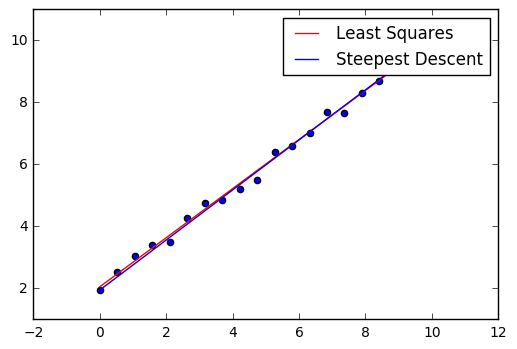

In [143]:
s_sd = steepest_descent(f, w0, w1, {w0: 0.4, w1: 1.1})

plt.plot([0, 10], [0*s_fit[0]+s_fit[1], 10*s_fit[0]+s_fit[1]], color='r', linestyle='-', label='Least Squares')
plt.plot([0, 10], [0*s_sd[w0]+s_sd[w1], 10*s_sd[w0]+s_sd[w1]], color='b', linestyle='-', label='Steepest Descent')
plt.scatter(samples[0,:], samples[1,:])
plt.legend()
plt.show()

Not quite, but also not far off from the reference. Variations of the steepest descent are the tools of the trade to train neural networks.

## Newton's method for function optimization

Next up is [Newton's method](https://en.wikipedia.org/wiki/Newton's_method_in_optimization), which frees us from a fixed step size when descenting. It comes at the cost that we need to compute second order derivatives. Although it is an iterative approach, Newton's method will take just one step for our problem setting. This is due to the fact that our object function has exactly the shape that Newton's method is approximating in each step.

In [145]:
def newton_descent(f, w0, w1, guess):
    d1 = cg.symbolic_gradient(f)        # gives df/dw0, df/dw1
    d2w0 = cg.symbolic_gradient(d1[w0]) # gives ddf/dw0dw0, ddf/dw0dw1,
    d2w1 = cg.symbolic_gradient(d1[w1]) # gives ddf/dw1dw1, ddf/dw1dw0,

    def nhessian(guess):
        h = np.zeros((2,2))
        h[0,0] = cg.value(d2w0[w0], guess)
        h[0,1] = cg.value(d2w0[w1], guess)
        h[1,0] = cg.value(d2w1[w0], guess)
        h[1,1] = cg.value(d2w1[w1], guess)
        return h

    def ngrad(guess):
        g = np.zeros((2,1))
        g[0, 0] = cg.value(d1[w0], guess)
        g[1, 0] = cg.value(d1[w1], guess)
        return g

    # Single step is enough, since our objective function is of quadric shape.
    step = np.linalg.inv(nhessian(guess)).dot(ngrad(guess))
    guess[w0] -= step[0,0]
    guess[w1] -= step[1,0]

    print('Newton solution {}, {}'.format(guess[w0], guess[w1]))
    print('Error {}'.format(cg.value(f, guess)))

    return guess

Newton solution 0.7918443819548725, 2.0527697830764446
Error 0.024826132543285872


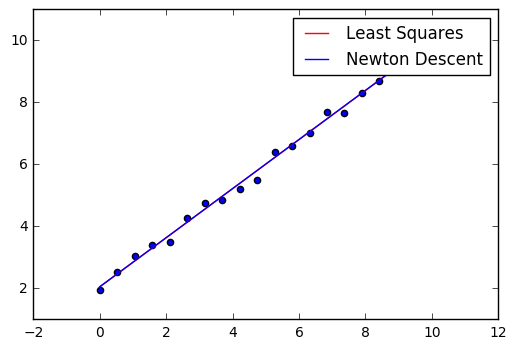

In [146]:
s_sn = newton_descent(f, w0, w1, {w0: 0.4, w1: 1.1})

plt.plot([0, 10], [0*s_fit[0]+s_fit[1], 10*s_fit[0]+s_fit[1]], color='r', linestyle='-', label='Least Squares')
plt.plot([0, 10], [0*s_sn[w0]+s_sn[w1], 10*s_sn[w0]+s_sn[w1]], color='b', linestyle='-', label='Newton Descent')
plt.scatter(samples[0,:], samples[1,:])
plt.legend()
plt.show()